# **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch, torch.nn as nn
from torchvision.io import decode_image, ImageReadMode
import torchvision as tv
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import os
from tqdm import tqdm
import copy
import utils

In [2]:
sns.set_theme(style="whitegrid", palette="Dark2")

# **Constants**

In [3]:
SEED = 10 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = ['notumor', 'glioma', 'meningioma', 'pituitary']
CLASSES_TO_NUM = {c:i for i,c in enumerate(CLASSES)}
NUM_TO_CLASSES = {i:c for i,c in enumerate(CLASSES)}
IMG_SHAPE = (224, 224)
N = 4
BATCH_SIZE = 32
EPOCHS = 40
LL_SAMPLES = 100

# **Data Exploration & Processing**

In [4]:
class BrainTumorMRI(Dataset):
    def __init__(self, path, classes=CLASSES, transform=None):
        self.path = path
        self.transform = transform
        self.index_table = self._make_index_table(path)
    def _make_index_table(self, path):
        tab = pd.DataFrame()
        for l,c in enumerate(CLASSES) :
            files = [f'{path}/{c}/{file}' for file in os.listdir(f'{path}/{c}')]
            labels = [l] * len(files)
            tab = pd.concat([tab, pd.DataFrame([files, labels]).T])
        return tab
    def __len__(self): return self.index_table.shape[0]
    def __getitem__(self, idx):
        img_file, label = self.index_table.iloc[idx]
        img = decode_image(img_file, mode=ImageReadMode.GRAY)
        if self.transform : img = self.transform(img)
        return img/255, label
        
img_process = tv.transforms.Compose([tv.transforms.Resize(IMG_SHAPE), nn.Threshold(20,0)])
train_dataset = BrainTumorMRI('data/Training', transform=img_process)
test_dataset = BrainTumorMRI('data/Testing', transform=img_process)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

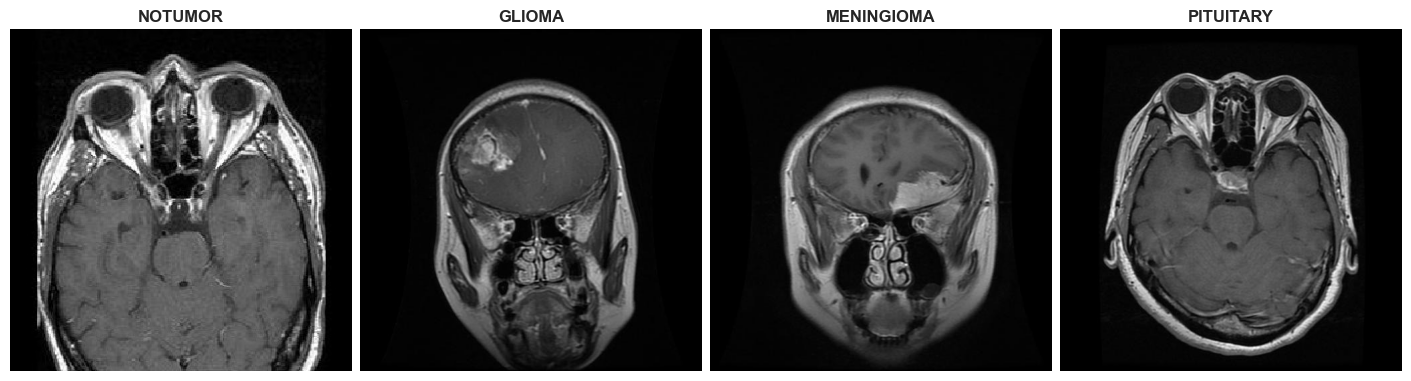

In [5]:
def view_data(dataset, classes=CLASSES, size=(14,4)):
    fig, ax = plt.subplots(1, len(classes), figsize=size, layout='constrained')
    for i,c in enumerate(classes):
        img = Image.open(dataset[dataset[1]==i].iloc[0][0])
        ax[i].axis('off')
        ax[i].set_title(c.upper(), fontsize=12, fontweight='bold')
        ax[i].imshow(img)

def view_data_examples(dataset, classes=CLASSES, n_examples=10, size=[14,8]):
    fig, ax = plt.subplots(len(classes), n_examples, figsize=size, layout='constrained')
    for i,c in enumerate(classes):
        for j in range(n_examples):
            img = Image.open(dataset[dataset[1]==i].iloc[j][0])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i,j].imshow(img)
        ax[i,0].set_ylabel(c.upper(), fontsize=12, fontweight='bold')

view_data(train_dataset.index_table)

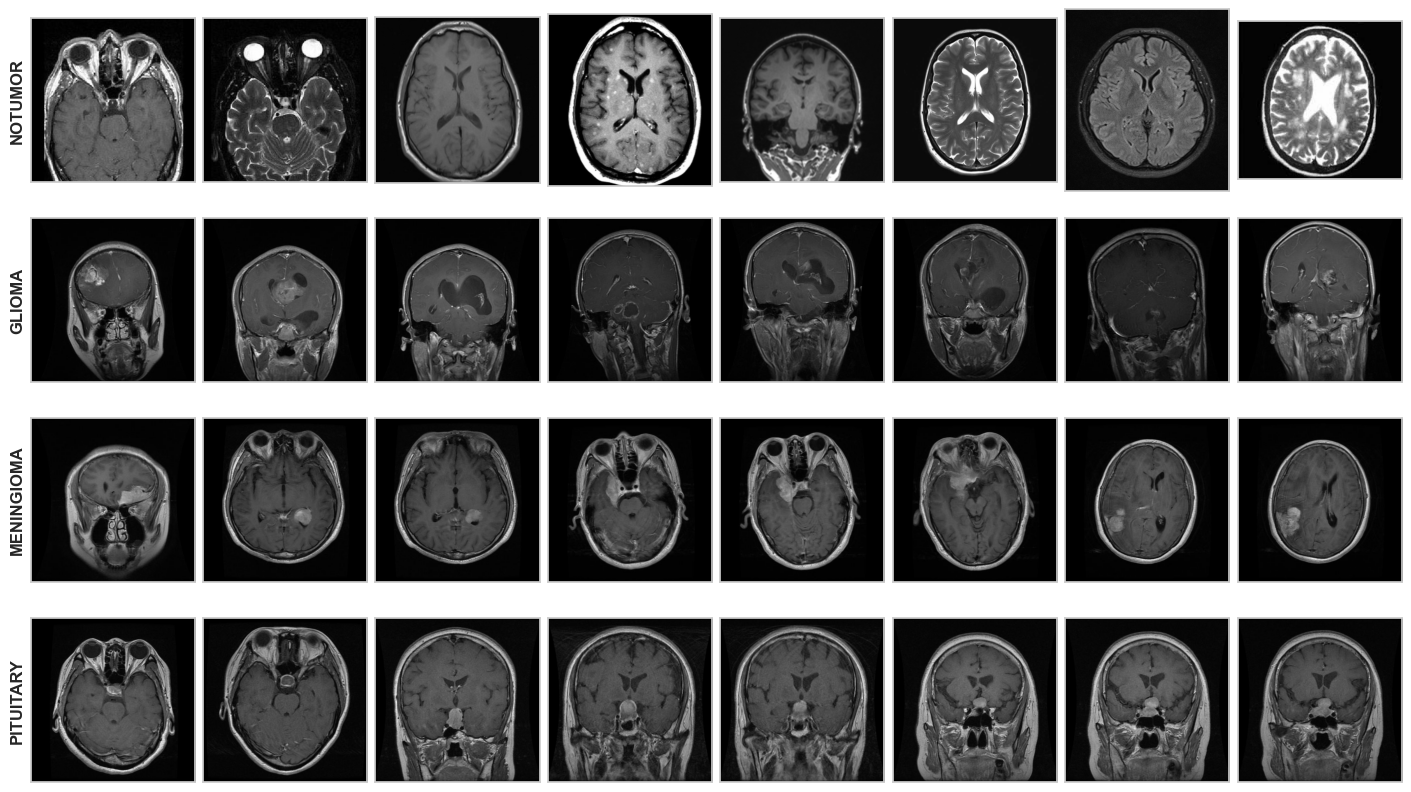

In [6]:
view_data_examples(train_dataset.index_table, n_examples=8)

# **Modeling** 

In [7]:
class ResNetModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2, 2), padding=(3, 3), bias=False)
    def forward(self, x):
        return self.model(x)
    
clf_resnet = ResNetModel(tv.models.resnet18(num_classes=N)).to(DEVICE)

In [8]:
def train_fn(train_loader, model, loss_fn, optimizer, progress=True):
    loop = tqdm(train_loader) if progress else train_loader
    accs, losses = [], []
    for batch_idx, (x,y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        y_pred = out.argmax(axis=1)
        accuracy = (y_pred==y).to(float).mean()
        accs.append(accuracy.item())
        loss = loss_fn(out,y)
        losses.append(loss.item())
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        if progress : loop.set_postfix(loss=loss.item(), accuracy=accuracy.item()) 
    return model, sum(losses)/len(losses), sum(accs)/len(accs)
    
def test_fn(test_loader, model, loss_fn, progress=True, get_preds=False):
    loop = tqdm(test_loader) if progress else test_loader
    accs, losses = [], []
    y_test, y_preds = [], []
    model.eval()
    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(loop):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = out.argmax(axis=1)
            if get_preds:
                y_preds.append(out)
                y_test.append(y)
            accs.append((pred==y).to(float).mean().item())
            loss = loss_fn(out, y)
            losses.append(loss.item())
    return sum(losses)/len(losses), sum(accs)/len(accs), (torch.cat(y_preds), torch.cat(y_test)) if get_preds else None

def train_epochs(train_loader, test_loader, model, loss_fn, optimizer, epochs=EPOCHS, test=True, prog_train=True, prog_test=True):
    train_accs, train_losses, test_accs, test_losses = [], [], [], []
    loop = tqdm(range(epochs))
    # loop = range(epochs)
    try :
        for epoch in loop:
            model, train_loss, train_acc = train_fn(train_loader, model, loss_fn, optimizer, progress=prog_train)
            train_accs.append(train_acc)
            train_losses.append(train_loss)
            if test : 
                test_loss, test_acc, _ = test_fn(test_loader, model, loss_fn, progress=prog_test)
                test_accs.append(test_acc)
                test_losses.append(test_loss)
            loop.set_postfix(loss=sum(train_losses)/len(train_losses), accuracy=sum(train_accs)/len(train_accs))
    except KeyboardInterrupt:
        print(f'Stopped at epoch {epoch} with mean loss {train_loss} and accuracy {train_acc}')
    return model, train_accs, train_losses, test_accs, test_losses

def save_model_and_metrics(model, metrics, model_name):
    metrics_data = pd.DataFrame({name: col for name, col in zip(['train_acc', 'train_loss', 'test_acc', 'test_loss'],metrics)})
    metrics_data.to_csv(model_name+'_metrics.csv')
    torch.save({"model": model.state_dict()}, model_name+'.pth.tar')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_resnet.parameters(), weight_decay=1e-7)
clf_resnet, train_accs, train_losses, test_accs, test_losses = train_epochs(train_dataloader, test_dataloader, clf_resnet, loss_fn, optimizer, 
                                                                        epochs=EPOCHS, prog_train=False, prog_test=False)

100%|██████████| 40/40 [12:13<00:00, 18.35s/it, accuracy=0.939, loss=0.159]


# **Evaluation**

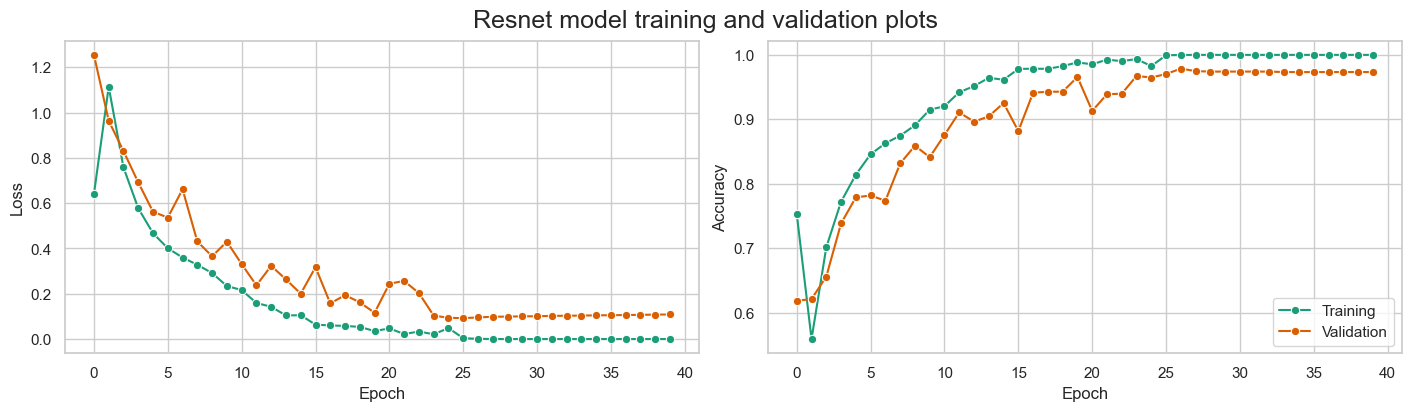

In [9]:
def plot_training(train_loss, test_loss, train_acc, test_acc, size=[14,4], title=''):
    fig, ax = plt.subplots(1,2, figsize=size, layout='constrained')
    sns.lineplot(ax=ax[0], data=train_loss, marker='o')
    sns.lineplot(ax=ax[0], data=test_loss, marker='o')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    sns.lineplot(ax=ax[1], data=train_acc, marker='o', label='Training')
    sns.lineplot(ax=ax[1], data=test_acc, marker='o', label='Validation')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='lower right')
    fig.suptitle(title, size=18)

plot_training(train_losses, test_losses, train_accs, test_accs, title='Resnet model training and validation plots')

100%|██████████| 41/41 [00:03<00:00, 13.51it/s]
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(
c:\Users\korda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


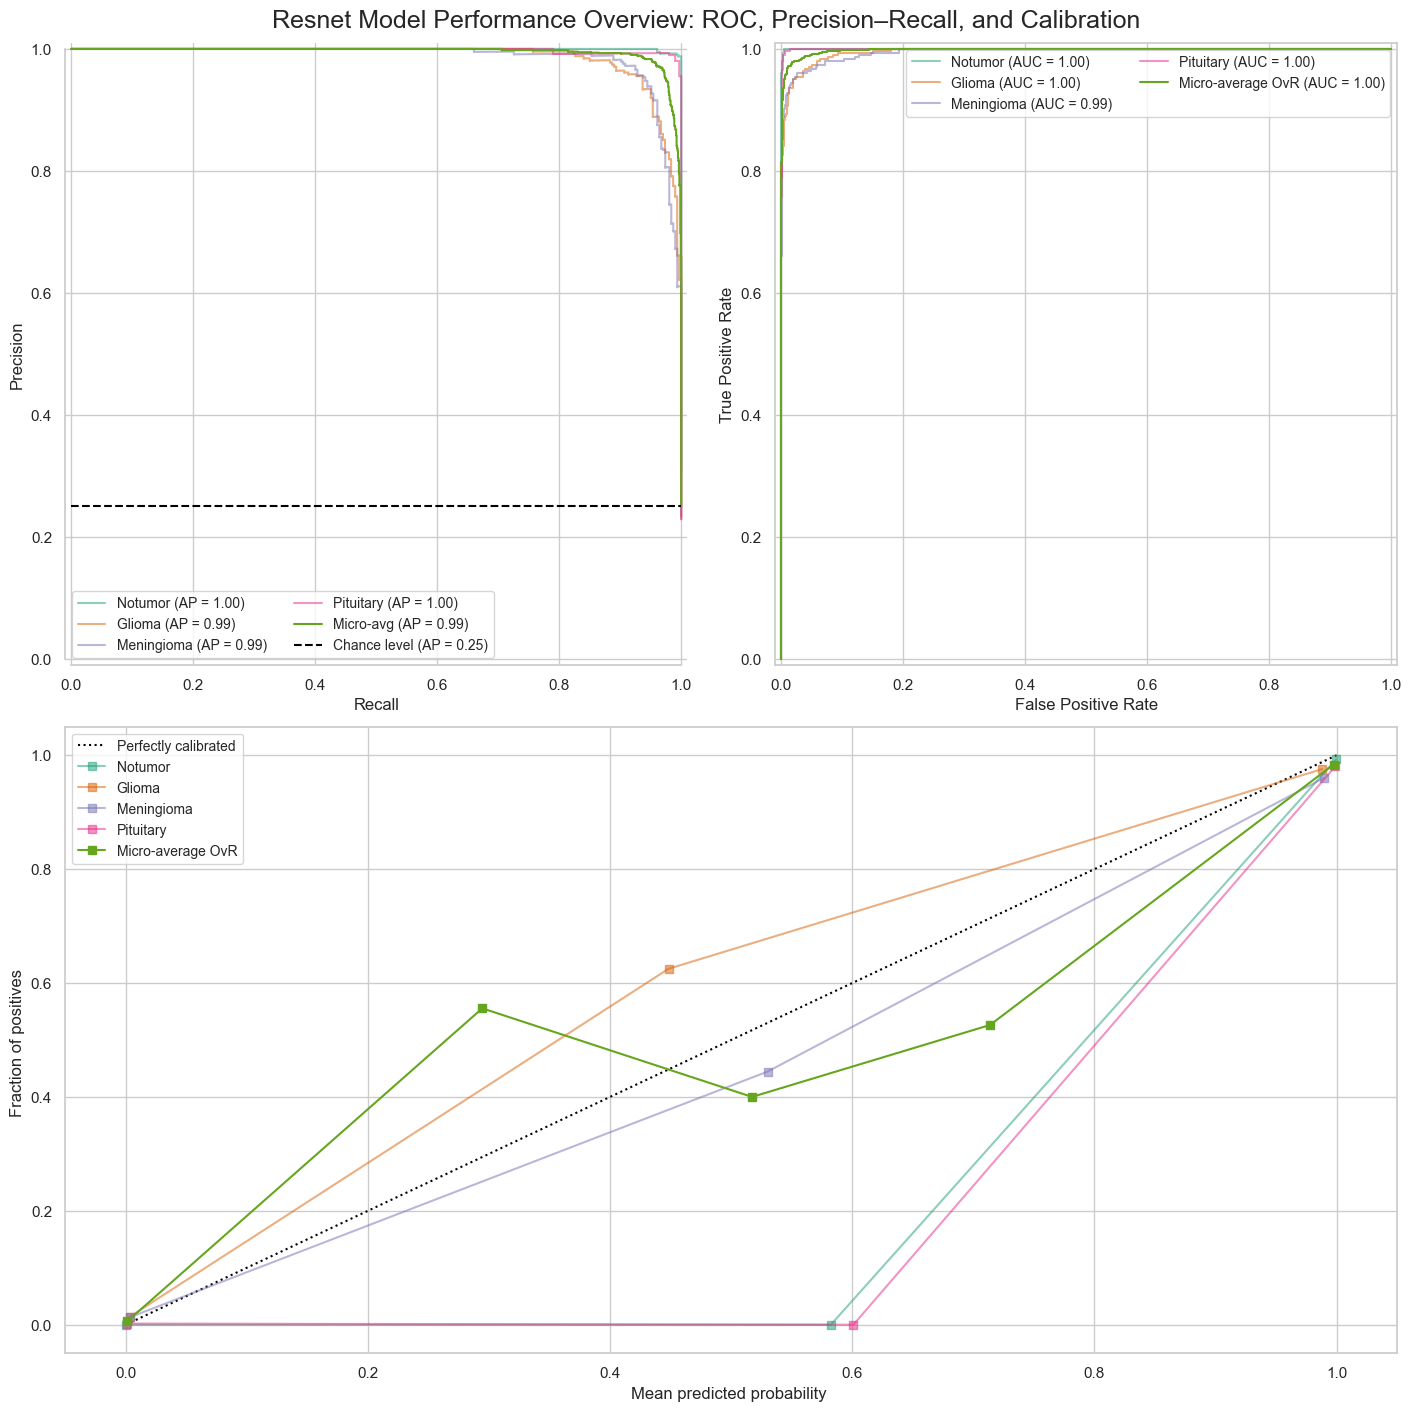

In [10]:
_, _, (y_score, y_test) = test_fn(test_dataloader, clf_resnet, loss_fn, get_preds=True)
utils.eval_summary(y_score.cpu(), torch.softmax(y_score, dim=1).cpu(), y_test.cpu(), title='Resnet Model Performance Overview: ROC, Precision–Recall, and Calibration')

In [14]:
def get_one_batch(loader, device=DEVICE):
    """"""
    x,y = next(iter(loader))
    return x.to(device), y.to(device)

def feature_maps_fn(x, model, layer_names):
    with torch.no_grad():
        model.eval()
        features = {}
        def hook_fn(name):
            def hook(module, input, output):
                features[name] = output.detach()
            return hook
        hooks = [model.model.get_submodule(layer).register_forward_hook(hook_fn(layer)) for layer in layer_names]
        model(x)        
        for h in hooks : h.remove()
        return features
    
def view_feature_map(x, model, layer_names, view_layer, idx=0):
    original_img = np.zeros(9, dtype='int').reshape(3,3).astype(str)
    layer_imgs = np.arange(1, 16, dtype='int').reshape(3,5).astype(str)
    img_locs = np.append(original_img, layer_imgs, axis=1)
    feature_map = feature_maps_fn(x, model, layer_names)
    fig, ax = plt.subplot_mosaic(img_locs, figsize=(14,5), layout='constrained')
    ax['0'].imshow(x[idx].permute(1,2,0).cpu())
    ax['0'].axis('off')
    for i in range(15):
        ax[str(i+1)].imshow(feature_map[view_layer][idx][i].unsqueeze(2).cpu())
        ax[str(i+1)].axis('off')
    fig.suptitle(f'Layer {view_layer[-1]} Feature Map', fontsize=16)

example1 = get_one_batch(test_dataloader)[0]
# feature_map = feature_maps_fn(example1, clf_resnet, ['layer'+str(i) for i in range(1,5)])

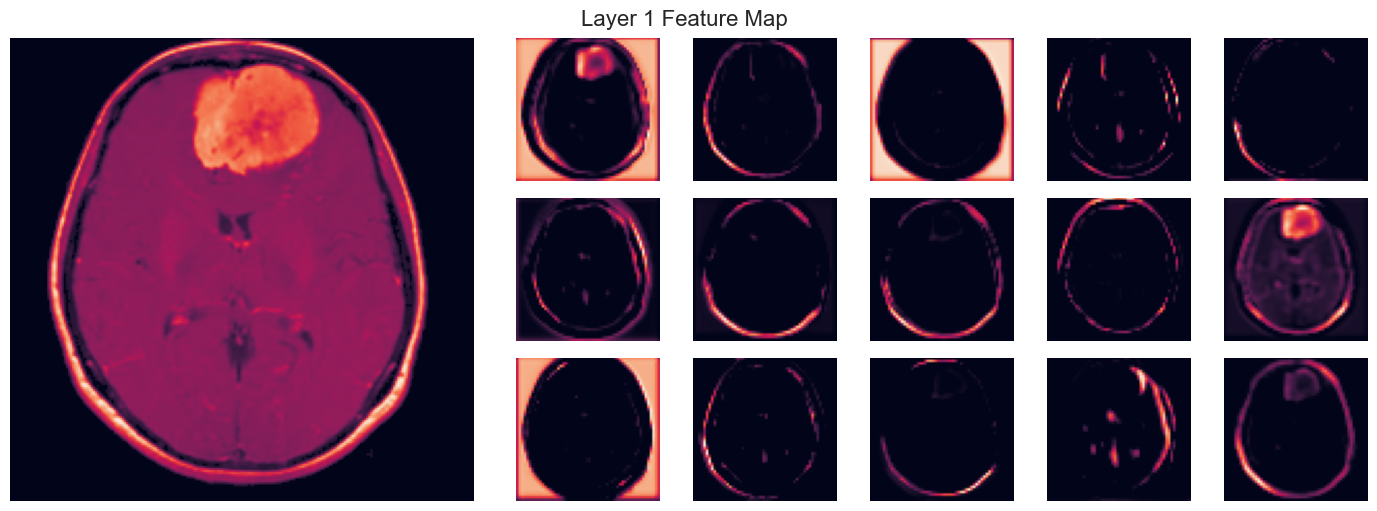

In [34]:
view_feature_map(example1, clf_resnet, ['layer'+str(i) for i in range(1,5)], 'layer1', idx=8)

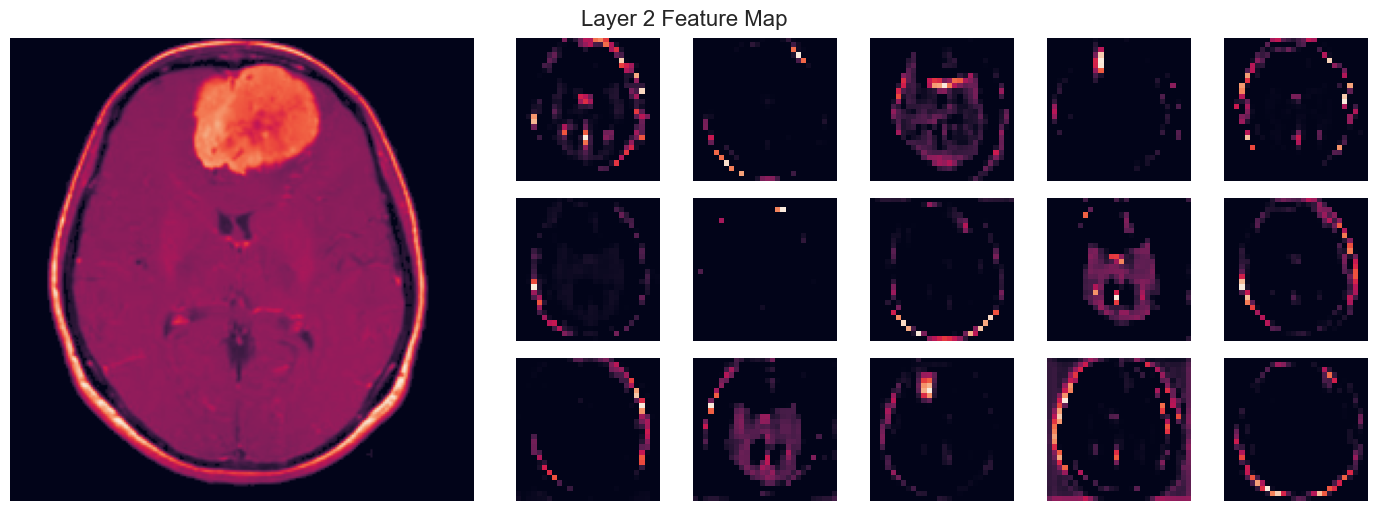

In [35]:
view_feature_map(example1, clf_resnet, ['layer'+str(i) for i in range(1,5)], 'layer2', idx=8)

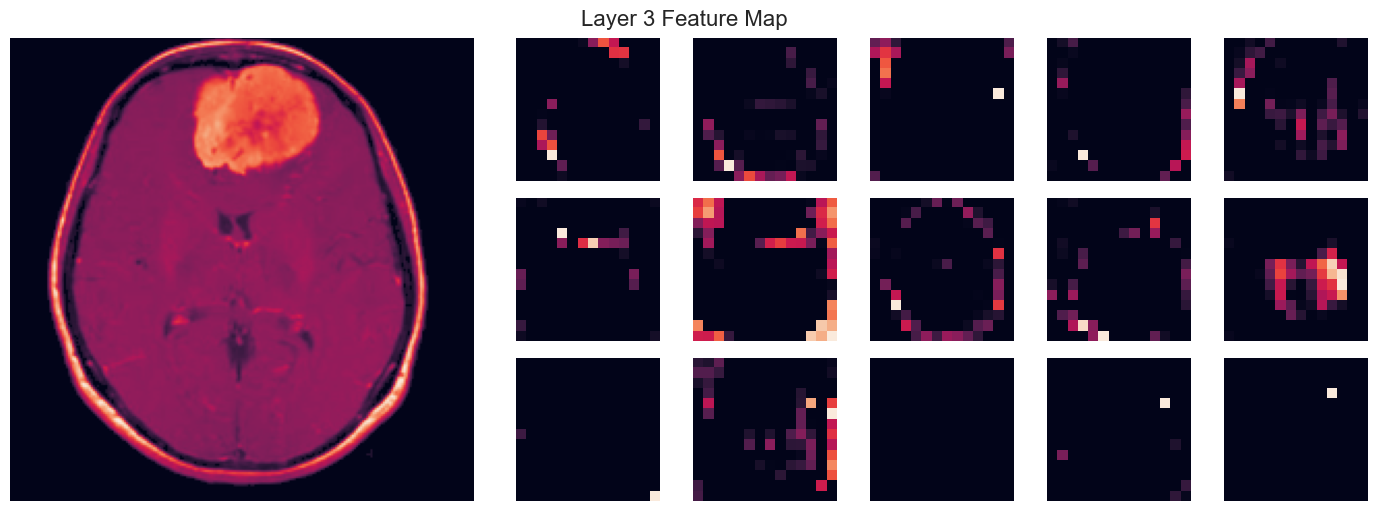

In [36]:
view_feature_map(example1, clf_resnet, ['layer'+str(i) for i in range(1,5)], 'layer3', idx=8)

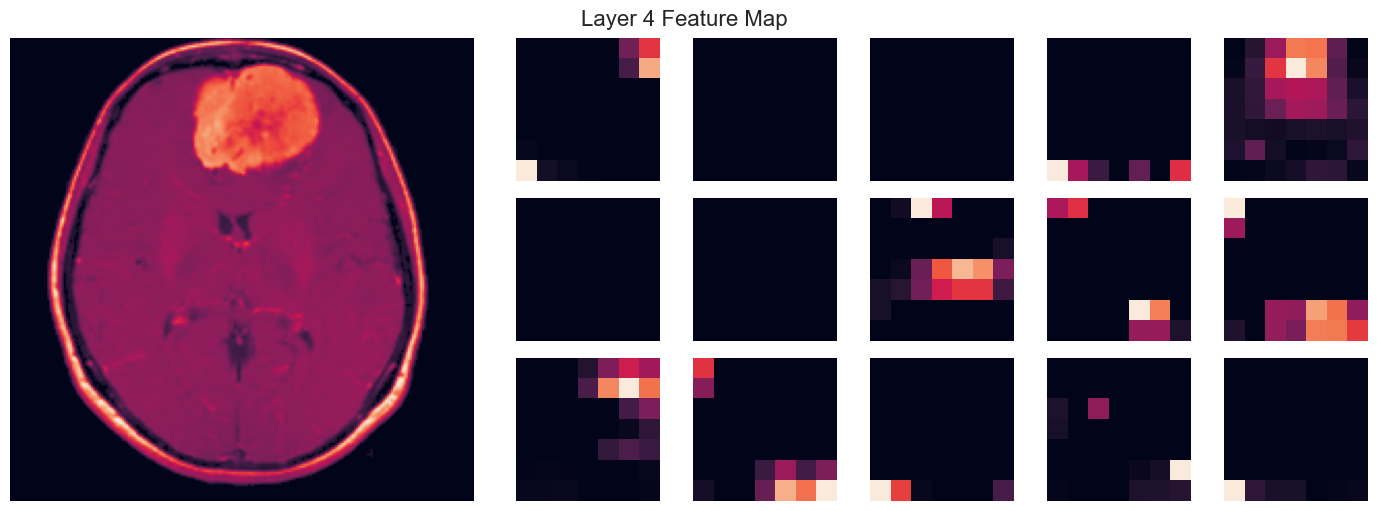

In [37]:
view_feature_map(example1, clf_resnet, ['layer'+str(i) for i in range(1,5)], 'layer4', idx=8)

# **Loss Landscape**

In [27]:
def get_direction_vectors(model):
    """"""
    u_vector = copy.deepcopy(model)
    v_vector = copy.deepcopy(model) 
    with torch.no_grad():
        for p in u_vector.parameters(): p.copy_(torch.randn_like(p))
        for p in v_vector.parameters(): p.copy_(torch.randn_like(p))
        for pu, pv, p in zip(u_vector.parameters(), v_vector.parameters(), model.parameters()): # Layers
            for fu, fv, fp in zip(pu,pv,p):                                                     # Filters
                fu_norm, fv_norm, fp_norm = torch.norm(fu), torch.norm(fv), torch.norm(fp)
                if fu_norm > 0: fu.mul_(fp_norm / fu_norm + 1e-8)
                if fv_norm > 0: fv.mul_(fp_norm / fv_norm + 1e-8)
    return u_vector, v_vector

def loss_landscape_fn(x, y, model, u_vector, v_vector, samples=LL_SAMPLES):
    """"""
    loss_landscape = []
    with torch.no_grad():
        alpha_range = beta_range = torch.linspace(-1.5,1.5,samples)
        for a in tqdm(alpha_range):
            loss_beta = []
            for b in beta_range:
                tmp_net = copy.deepcopy(model) # needs optimization
                tmp_net.eval()
                for p, pu, pv in zip(tmp_net.parameters(), u_vector.parameters(), v_vector.parameters()): p.add_(a*pu + b*pv)
                out = tmp_net(x.to(DEVICE))
                loss = loss_fn(out, y.to(DEVICE))
                loss_beta.append(loss.item())
            loss_landscape.append(loss_beta)
    return np.array(loss_landscape), alpha_range.numpy(), beta_range.numpy()

loss_landscape_full, alpha, beta = loss_landscape_fn(*get_one_batch(test_dataloader), clf_resnet, 
                                                     *get_direction_vectors(clf_resnet), samples=60)

100%|██████████| 60/60 [01:49<00:00,  1.82s/it]


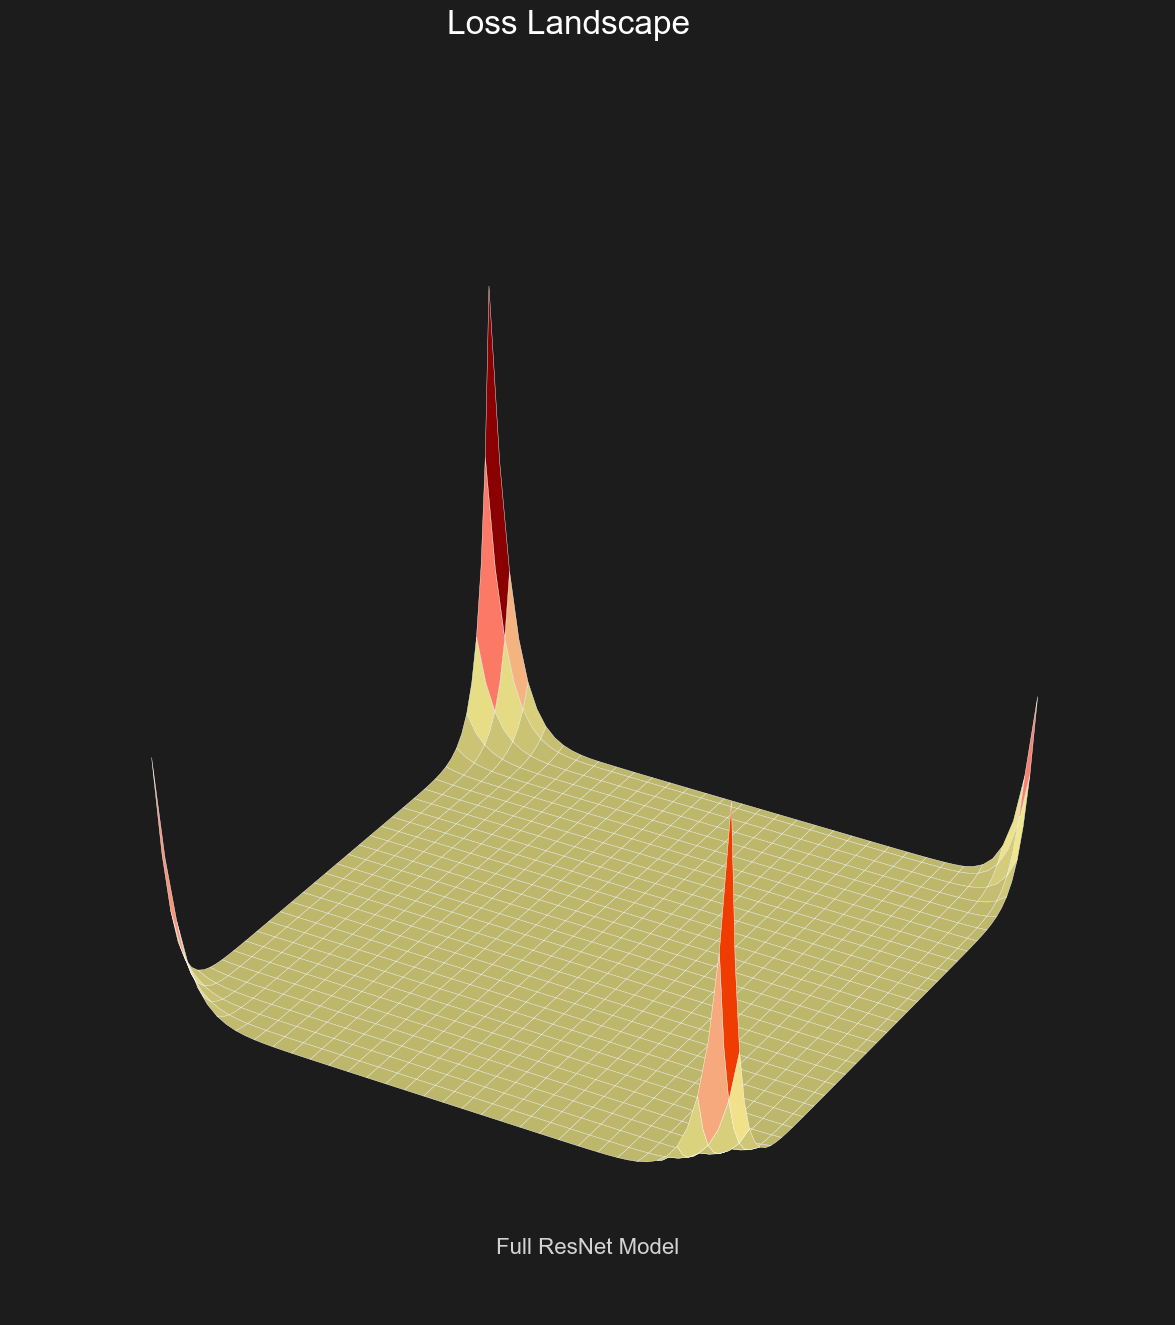

In [43]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(15,15))
alpha_, beta_ = np.meshgrid(alpha, beta)
cmap = LinearSegmentedColormap.from_list("custom", ["darkred", "orangered", "salmon", "khaki", "darkkhaki"][::-1])
ax.plot_surface(alpha_, beta_, loss_landscape_full, linewidth=.3, cmap=cmap)
ax.set_facecolor('#1c1c1c')
ax.axis('off')
ax.set_title('Full ResNet Model', y=0.05, color='lightgray', size=16)
fig.patch.set_facecolor('#1c1c1c')
_ = fig.suptitle('Loss Landscape', color='white', fontsize=24)